# 有多少人是知道G@C可回收物 但沒有去做回收的，比如：有多少%受訪者是知道[玻璃樽]是可回收的 但卻並沒有在過去12個月内進行過回收

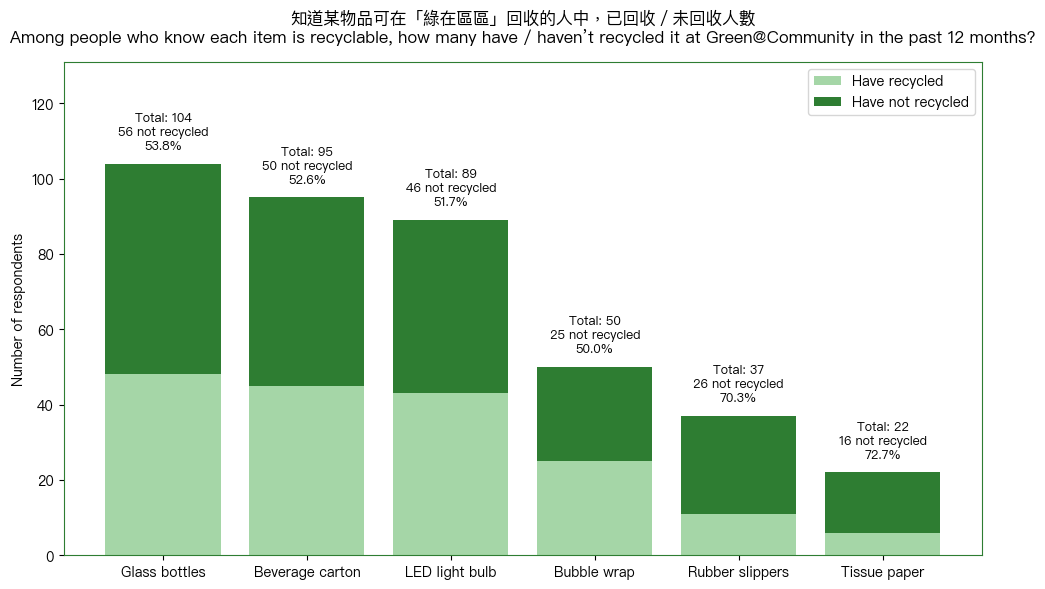

In [1]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

# ---------- load data ----------
data_path = Path("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- locate the recyclable-items multi-select column ----------
items_patterns = [
    r"identify\s+which\s+of\s+the\s+following\s+item\(s\)\s+can\s+be\s+recycled\s+at\s+green@community\s+facilities",
    r"請指出下列哪些物品可以在.*綠在區區.*設施進行回收",
]

def find_col(columns, patterns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    # try explicit patterns first
    for c, norm in cols:
        if any(re.search(p, norm, flags=re.IGNORECASE) for p in patterns):
            return c
    # fallback heuristic
    for c, norm in cols:
        if re.search(r"green@community", norm, flags=re.IGNORECASE) and \
           re.search(r"recycl", norm, flags=re.IGNORECASE):
            return c
    return None

items_col = find_col(df.columns, items_patterns)
if items_col is None:
    raise RuntimeError("Could not find the recyclable-items checkbox column.")

items_series = df[items_col].fillna("").astype(str)

# ---------- locate the 12-months usage (Yes/No) column ----------
use_patterns = [
    r"in\s+the\s+past\s+12\s+months.*used\s+any\s+green@community\s+recycling\s+facility",
    r"在最近12個月.*有否使用過.*綠在區區.*回收設施",
]

use_col = find_col(df.columns, use_patterns)
if use_col is None:
    raise RuntimeError("Could not find the 'past 12 months use' Yes/No column.")

use_series = df[use_col].astype(str)

# ---------- parse items into sets ----------
def parse_items(cell: str):
    # split by comma, keep cleaned choice names from the CLEANED DATA
    return {part.strip() for part in cell.split(",") if part.strip()}

parsed_items = items_series.apply(parse_items)

# all distinct options from CLEANED DATA
all_items = sorted(set().union(*parsed_items))

# remove "Have no idea" from the items list
items_to_use = [it for it in all_items if it.lower() != "have no idea"]

# optional: keep questionnaire order if present
preferred_order = [
    "Beverage carton",
    "Bubble wrap",
    "Glass bottles",
    "LED light bulb",
    "Rubber slippers",
    "Tissue paper",
]
ordered_items = [it for it in preferred_order if it in items_to_use] + \
                [it for it in items_to_use if it not in preferred_order]

# ---------- map Yes/No usage ----------
def used_facility(text):
    s = str(text).strip().lower()
    if s in {"yes", "y", "是", "有"}:
        return True
    if s in {"no", "n", "否", "沒有", "未有", "無"}:
        return False
    return None

use_flags = use_series.map(used_facility)

# masks of respondents who HAVE and HAVE NOT used the facility
mask_used     = (use_flags == True)
mask_not_used = (use_flags == False)

# ---------- counts: know item is recyclable & used / not used ----------
counts_not_used = []
counts_used     = []

for item in ordered_items:
    # respondent knows item -> item selected in their multi-select answer
    knows_item = parsed_items.apply(lambda s: item in s)

    count_not_used = int(((knows_item) & mask_not_used).sum())
    count_used     = int(((knows_item) & mask_used).sum())

    counts_not_used.append(count_not_used)
    counts_used.append(count_used)

# ---------- NEW: sort bars by total count (DESC) ----------
totals = [u + n for u, n in zip(counts_used, counts_not_used)]
sorted_idx = sorted(range(len(ordered_items)), key=lambda i: totals[i], reverse=True)

ordered_items = [ordered_items[i]     for i in sorted_idx]
counts_used   = [counts_used[i]       for i in sorted_idx]
counts_not_used = [counts_not_used[i] for i in sorted_idx]

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK",
                  "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = font_name
        break
plt.rcParams["axes.unicode_minus"] = False

# ---------- plot stacked bar chart ----------
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
ax.set_facecolor("white")

x = range(len(ordered_items))

color_used     = "#a5d6a7"  # light green - have recycled
color_not_used = "#2e7d32"  # dark green  - have NOT recycled

# green border for the axes
for spine in ax.spines.values():
    spine.set_color(color_not_used)

bars_used = ax.bar(x, counts_used, color=color_used, label="Have recycled")
bars_not  = ax.bar(
    x,
    counts_not_used,
    bottom=counts_used,
    color=color_not_used,
    label="Have not recycled",
)

# add labels for "have not recycled" (Total + count + % among those who know that item)
max_total = max(u + n for u, n in zip(counts_used, counts_not_used)) if ordered_items else 0
ax.set_ylim(0, max_total * 1.25 + 1)

for i, (used, not_used) in enumerate(zip(counts_used, counts_not_used)):
    total_knows = used + not_used
    pct_not = (not_used / total_knows * 100) if total_knows > 0 else 0.0
    ax.text(
        i,
        total_knows + max(1, max_total * 0.03),
        f"Total: {total_knows}\n{not_used} not recycled\n{pct_not:.1f}%",
        ha="center",
        va="bottom",
        fontsize=9,
    )

ax.set_xticks(list(x))
ax.set_xticklabels(ordered_items, rotation=0, ha="center")
ax.set_ylabel("Number of respondents")

title_cn = "知道某物品可在「綠在區區」回收的人中，已回收／未回收人數"
title_en = "Among people who know each item is recyclable, how many have / haven’t recycled it at Green@Community in the past 12 months?"
ax.set_title(title_cn + "\n" + title_en, pad=14)

ax.legend(loc="upper right")

plt.tight_layout()
plt.show()
